## Data Cleaning

In [101]:
import pandas as pd
import sqlite3
import numpy as np
import seaborn as sns
from sklearn import preprocessing

### The Movie Data Base

In [107]:
# read data in
tmdb = pd.read_csv('Data/tmdb.movies.csv', index_col=0)
tmdb.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [108]:
tmdb.shape

(26517, 9)

In [109]:
tmdb.isna().any()

genre_ids            False
id                   False
original_language    False
original_title       False
popularity           False
release_date         False
title                False
vote_average         False
vote_count           False
dtype: bool

In [110]:
tmdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26517 entries, 0 to 26516
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   genre_ids          26517 non-null  object 
 1   id                 26517 non-null  int64  
 2   original_language  26517 non-null  object 
 3   original_title     26517 non-null  object 
 4   popularity         26517 non-null  float64
 5   release_date       26517 non-null  object 
 6   title              26517 non-null  object 
 7   vote_average       26517 non-null  float64
 8   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 2.0+ MB


Here we can see that our release date isn't being treated as a datetime object. The genre IDs will also be more useful as lists rather than strings

In [111]:
# change release date to datetime
tmdb.release_date = pd.to_datetime(tmdb.release_date)
# turn genre ids into lists
tmdb.genre_ids = tmdb.genre_ids.str.strip('[]').str.split(',')
# remove whitespace from genre ids
tmdb.genre_ids = tmdb.genre_ids.apply(lambda x: [y.strip() for y in x])
# add release month column
tmdb['release_month'] = tmdb.release_date.dt.month
tmdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   genre_ids          26517 non-null  object        
 1   id                 26517 non-null  int64         
 2   original_language  26517 non-null  object        
 3   original_title     26517 non-null  object        
 4   popularity         26517 non-null  float64       
 5   release_date       26517 non-null  datetime64[ns]
 6   title              26517 non-null  object        
 7   vote_average       26517 non-null  float64       
 8   vote_count         26517 non-null  int64         
 9   release_month      26517 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 2.2+ MB


In [112]:
tmdb.describe()

,id,popularity,vote_average,vote_count,release_month
count,26517.000000,26517.000000,26517.000000,26517.000000,26517.000000
mean,295050.153260,3.130912,5.991281,194.224837,6.405966
std,153661.615648,4.355229,1.852946,960.961095,3.573796
min,27.000000,0.600000,0.000000,1.000000,1.000000
25%,157851.000000,0.600000,5.000000,2.000000,3.000000
50%,309581.000000,1.374000,6.000000,5.000000,6.000000
75%,419542.000000,3.694000,7.000000,28.000000,10.000000
max,608444.000000,80.773000,10.000000,22186.000000,12.000000


Here we can see that many of the movies have very few votes under vote count which may influence the overall rating for that movie. We should make sure that there are a reasonable amount of votes before continuing with our analysis

In [113]:
# remove rows where there are fewer than 28 votes
tmdb_final = tmdb.query('vote_count >= 100').copy()
print(tmdb_final.shape)
tmdb_final.describe()

(3686, 10)


,id,popularity,vote_average,vote_count,release_month
count,3686.000000,3686.000000,3686.000000,3686.000000,3686.000000
mean,223283.718394,11.281023,6.389392,1325.535269,6.974498
std,144382.238450,6.196958,0.862305,2270.643058,3.449799
min,27.000000,0.600000,2.000000,100.000000,1.000000
25%,78090.500000,7.557750,5.800000,186.000000,4.000000
50%,234102.000000,9.395000,6.400000,422.000000,7.000000
75%,339966.250000,12.894000,7.000000,1306.000000,10.000000
max,569547.000000,80.773000,8.600000,22186.000000,12.000000


In [114]:
# create a new dataframe where the genre ids are separated
ids = []
genre_ids = []
vote_averages = []

popularity_by_genre = {'id': ids, 'genre_ids': genre_ids, 'vote_average': vote_averages}

for index, row in tmdb_final.iterrows():
    for genre in row[0]:
        ids.append(row[1])
        genre_ids.append(genre)
        vote_averages.append(row[7])

popularity_by_genre = pd.DataFrame(popularity_by_genre)
popularity_by_genre

,id,genre_ids,vote_average
0,12444,12,7.7
1,12444,14,7.7
2,12444,10751,7.7
3,10191,14,7.7
4,10191,12,7.7
...,...,...,...
9194,531949,35,5.3
9195,489430,27,6.4
9196,5961,14,7.8
9197,5961,18,7.8


In [115]:
genre_mappings = {
    '28': 'Action',
    '12': 'Adventure',
    '16': 'Animation',
    '35': 'Comedy',
    '80': 'Crime',
    '99': 'Documentary',
    '18': 'Drama',
    '10751': 'Family',
    '14': 'Fantasy',
    '36': 'History',
    '27': 'Horror',
    '10402': 'Music',
    '9648': 'Mystery',
    '10749': 'Romance',
    '878': 'Science Fiction',
    '10770': 'TV Movie',
    '53': 'Thriller',
    '10752': 'War',
    '37': 'Western'
}

popularity_by_genre['genre'] = popularity_by_genre.genre_ids.map(genre_mappings)
popularity_by_genre.head()

,id,genre_ids,vote_average,genre
0,12444,12,7.7,Adventure
1,12444,14,7.7,Fantasy
2,12444,10751,7.7,Family
3,10191,14,7.7,Fantasy
4,10191,12,7.7,Adventure


In [116]:
popularity_by_genre[['genre_ids', 'vote_average']].groupby('genre_ids').describe()

vote_average                                                
                 count      mean       std  min    25%   50%  75%  max
genre_ids                                                             
10402            100.0  6.755000  0.822459  4.9  6.275  6.70  7.4  8.4
10749            515.0  6.531845  0.780898  4.0  6.000  6.50  7.1  8.6
10751            341.0  6.565103  0.813697  4.2  5.900  6.60  7.1  8.5
10752             96.0  6.876042  0.751804  5.1  6.375  6.85  7.4  8.5
10770             65.0  6.393846  0.914446  3.5  6.100  6.40  7.0  7.9
12               516.0  6.414922  0.805750  3.8  5.900  6.40  7.0  8.4
14               355.0  6.446761  0.824628  4.0  5.900  6.40  7.0  8.5
16               320.0  6.827187  0.788382  4.2  6.300  6.80  7.4  8.6
18              1779.0  6.615683  0.789103  2.8  6.100  6.70  7.2  8.6
27               531.0  5.680414  0.775055  2.0  5.200  5.70  6.2  7.7
28               798.0  6.241855  0.816688  3.5  5.700  6.20  6.8  8.4
35              1154.0  6.288995  0.788353  3.3  5.800  6.30  6.8  8.4
36               161.0  6.949068  0.702417  4.5  6.500  7.00  7.4  8.5
37                41.0  6.463415  0.850516  4.6  5.800  6.50  7.2  8.0
53              1080.0  6.085093  0.786794  3.3  5.600  6.10  6.6  8.3
80               478.0  6.348745  0.747511  4.1  5.800  6.30  6.9  8.4
878              424.0  6.232075  0.932578  2.0  5.600  6.20  6.9  8.4
9648             323.0  6.200000  0.842136  3.3  5.700  6.20  6.7  8.2
99               122.0  7.346721  0.651658  5.1  6.925  7.40  7.8  8.6

### Movie Budgets

In [124]:
movie_budgets = pd.read_csv('Data/tn.movie_budgets.csv')
print(movie_budgets.shape)
movie_budgets.head()

(5782, 6)


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [125]:
movie_budgets.isna().any()

id                   False
release_date         False
movie                False
production_budget    False
domestic_gross       False
worldwide_gross      False
dtype: bool

In [126]:
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [127]:
movie_budgets['production_budget'] = (movie_budgets['production_budget']
                                      .str.replace(',', '')
                                      .str.replace('$', '')
                                      .astype(float))

movie_budgets['domestic_gross'] = (movie_budgets['domestic_gross']
                                   .str.replace(',', '')
                                   .str.replace('$', '')
                                   .astype(float))

movie_budgets['worldwide_gross'] = (movie_budgets['worldwide_gross']
                                    .str.replace(',', '')
                                    .str.replace('$', '')
                                    .astype(float))

In [128]:
movie_budgets['release_date'] = pd.to_datetime(movie_budgets['release_date'])

In [129]:
movie_budgets['budget_to_domestic_gross'] = movie_budgets.domestic_gross / movie_budgets.production_budget

In [136]:
tmdb_with_budgets = pd.merge(tmdb_final, movie_budgets,  how='inner', left_on=['title','release_date'], right_on = ['movie','release_date'])

In [140]:
tmdb_with_budgets['income'] = tmdb_with_budgets.domestic_gross - tmdb_with_budgets.production_budget

In [141]:
tmdb_with_budgets

,genre_ids,id_x,original_language,original_title,popularity,release_date,title,vote_average,vote_count,release_month,id_y,movie,production_budget,domestic_gross,worldwide_gross,budget_to_domestic_gross,income
0,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,3,30,How to Train Your Dragon,165000000.0,217581232.0,494870992.0,1.318674,52581232.0
1,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,5,15,Iron Man 2,170000000.0,312433331.0,621156389.0,1.837843,142433331.0
2,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174,11,37,Toy Story,30000000.0,191796233.0,364545516.0,6.393208,161796233.0
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174,11,37,Toy Story,30000000.0,191796233.0,364545516.0,6.393208,161796233.0
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186,7,38,Inception,160000000.0,292576195.0,835524642.0,1.828601,132576195.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235,"[18, 53]",464502,en,Acrimony,10.600,2018-03-30,Acrimony,6.6,186,3,35,Acrimony,20000000.0,43549096.0,46627836.0,2.177455,23549096.0
1236,"[80, 18, 36, 53]",339103,en,Gotti,10.034,2018-06-15,Gotti,5.2,231,6,64,Gotti,10000000.0,4286367.0,6089100.0,0.428637,-5713633.0
1237,"[18, 10751, 10402]",470878,en,I Can Only Imagine,9.700,2018-03-16,I Can Only Imagine,7.6,155,3,90,I Can Only Imagine,7000000.0,83482352.0,85604221.0,11.926050,76482352.0
1238,"[53, 28, 80]",442064,en,Proud Mary,9.371,2018-01-12,Proud Mary,5.5,259,1,50,Proud Mary,30000000.0,20868638.0,21709539.0,0.695621,-9131362.0


<AxesSubplot:xlabel='vote_average', ylabel='income'>

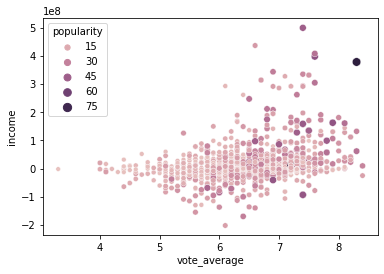

In [146]:
sns.scatterplot(data=tmdb_with_budgets, x='vote_average', y='income', size='popularity', hue='popularity')

## Data Understanding

In [117]:
# generate box and whisker plots to make case for normalization or remove outliers
tmdb_final.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,release_month
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,11
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,3
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,5
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174,11
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186,7


In [ ]:
tmdb_final['Action'] = 'Action' in tmdb_final['genre_ids']

genres = []

for genre_list in tmdb_final.genre_ids:
    for genre in genre_list:
        if genre not in genres:
            genre.append(genre)

for genre in genres

c:\Users\sreichlin\Anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


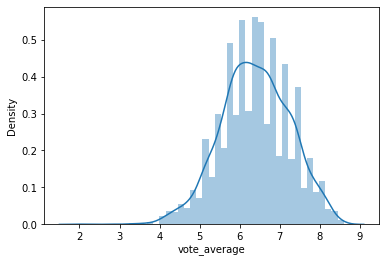

In [118]:
sns.distplot(tmdb_final.vote_average);

Here we can see that the average ratings follow a fairly normal distribution; however, we can see that there are somewhat regular spikes in the distribution where rating values are much more common

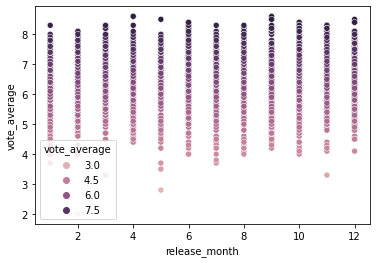

In [119]:

sns.scatterplot(x='release_month', y='vote_average', data=tmdb_final, hue='vote_average');

In [120]:
popularity_by_genre.head()

,id,genre_ids,vote_average,genre
0,12444,12,7.7,Adventure
1,12444,14,7.7,Fantasy
2,12444,10751,7.7,Family
3,10191,14,7.7,Fantasy
4,10191,12,7.7,Adventure


<AxesSubplot:xlabel='id', ylabel='vote_average'>

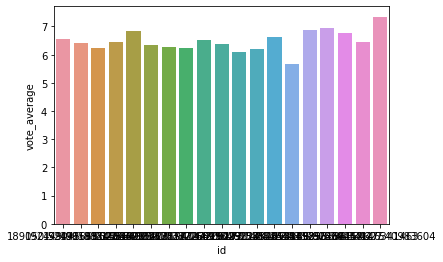

In [121]:
sns.barplot(x='id', y='vote_average', data=popularity_by_genre.groupby(by='genre').mean())

In [122]:
popularity_by_genre.groupby(by='genre').mean()

,id,vote_average
genre,,
Action,199045.883459,6.241855
Adventure,192449.065891,6.414922
Animation,202564.021875,6.827187
Comedy,215017.671577,6.288995
Crime,214549.914226,6.348745
Documentary,274457.475410,7.346721
Drama,229314.524452,6.615683
Family,189050.524927,6.565103
Fantasy,199193.318310,6.446761


In [123]:
tmdb_final.sort_values('vote_average', ascending=False).head(20)

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,release_month
17389,"[10749, 16, 18]",372058,ja,君の名は。,28.238,2017-04-07,Your Name.,8.6,4161,4
14711,[99],359364,fr,Human,5.734,2015-09-11,Human,8.6,155,9
20632,"[10749, 16, 18]",372058,ja,君の名は。,28.238,2017-04-07,Your Name.,8.6,4161,4
23861,"[18, 36, 10752]",424,en,Schindler's List,25.334,1993-12-15,Schindler's List,8.5,8065,12
14173,"[16, 10751, 14]",129,ja,千と千尋の神隠し,32.043,2002-09-20,Spirited Away,8.5,7424,9
17819,[99],377462,en,O.J. Made in America,6.939,2016-05-20,O.J. Made in America,8.5,115,5
20626,"[16, 10751, 14]",129,ja,千と千尋の神隠し,32.043,2002-09-20,Spirited Away,8.5,7424,9
5201,"[18, 80]",311,en,Once Upon a Time in America,17.717,1984-06-01,Once Upon a Time in America,8.4,2243,6
23899,[18],517814,ar,کفرناحوم,20.249,2018-12-14,Capernaum,8.4,329,12
11031,"[18, 10402]",244786,en,Whiplash,28.784,2014-10-10,Whiplash,8.4,7908,10


In [ ]:
# something that shows correlation between movie ratings and box office success